In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pmdarima
from pmdarima import auto_arima
from sklearn.linear_model import LinearRegression
import requests

In [2]:
rcParams['figure.figsize']=20,10

In [3]:
#!pip install --user pmdarima

In [4]:
stock_json = requests.get("https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=TECHM.NS&outputsize=full&apikey=8GILHF199FBEE47U")
stock_json.status_code

200

In [5]:
df_0 = pd.DataFrame(stock_json.json()['Time Series (Daily)']).transpose()
df_0.head()

,1. open,2. high,3. low,4. close,5. volume
2020-06-02,543.6000,548.3500,538.0000,547.5000,3877962
2020-06-01,538.5000,554.8000,537.0500,543.5500,4913055
2020-05-29,529.9000,535.6500,524.4500,530.4500,4081245
2020-05-28,528.0000,531.8500,517.1500,529.7000,3387672
2020-05-27,521.6500,526.0000,512.0500,523.7500,2265885


In [6]:
df_0.rename(columns={'1. open':'Open', '2. high': 'High', '3. low':'Low', '4. close':'Close', '5. volume': 'Volume'}, inplace = True)
df_0.index.rename('Date', inplace=True)
df_0.index.rename('Date', inplace=True)
df_0.index = pd.to_datetime(df_0.index)
df_0.sort_index(inplace=True)

In [7]:
df_0.head()

,Open,High,Low,Close,Volume
Date,,,,,
2006-08-28,130.2500,142.2500,125.5000,138.5620,60664652
2006-08-29,138.7500,140.9750,133.8870,134.8250,15716452
2006-08-30,134.2500,135.7250,130.3750,132.0250,8139932
2006-08-31,131.2500,136.0000,128.7500,134.6130,6683960
2006-09-01,134.7500,137.2500,133.7750,135.4620,4704780


In [8]:
df = df_0.copy()

### Exploration

In [9]:
df.shape

(3380, 5)

In [10]:
df.dtypes

Open      object
High      object
Low       object
Close     object
Volume    object
dtype: object

- Since they are all object, instead of numbers, we need to first convert them to numbers

In [11]:
df['Open'] = pd.to_numeric(df['Open']) 
df['High'] = pd.to_numeric(df['High']) 
df['Low'] = pd.to_numeric(df['Low']) 
df['Close'] = pd.to_numeric(df['Close']) 
df['Volume'] = pd.to_numeric(df['Volume']) 

In [12]:
df.dtypes

Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object

In [13]:
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [14]:
pd.DataFrame(df['Close'].describe())

,Close
count,3380.000000
mean,387.402624
std,207.699668
min,52.325000
25%,189.806000
50%,377.200000
75%,534.912500
max,840.900000


In [15]:
df_close = df['Close']
df_close = df_close[:len(df_close)-62]

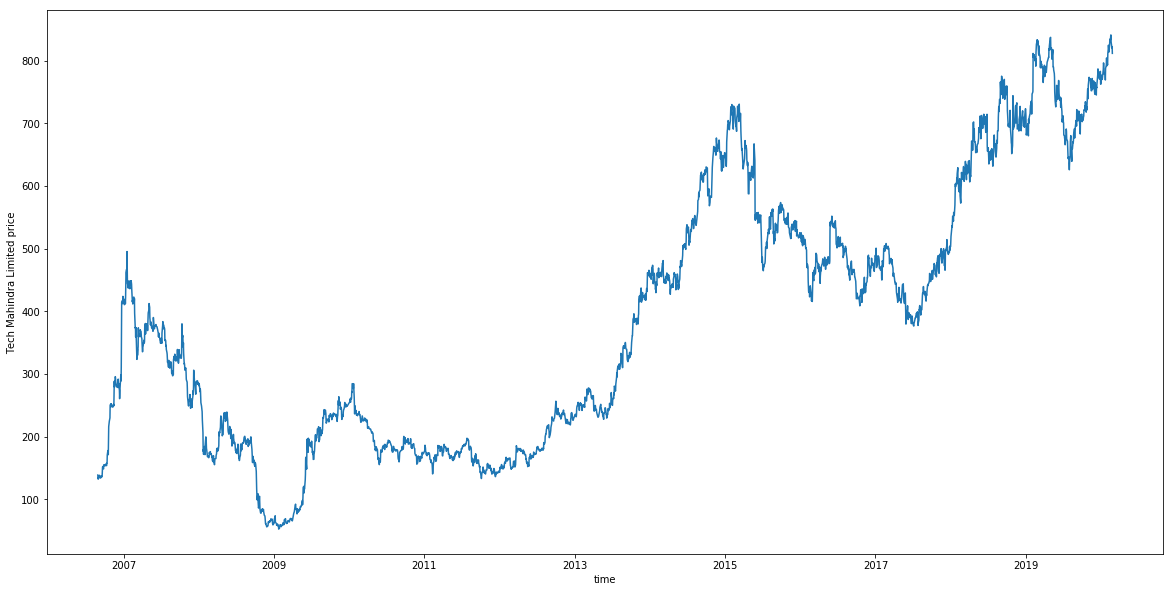

In [16]:
plt.plot(df_close)
plt.xlabel("time")
plt.ylabel("Tech Mahindra Limited price");

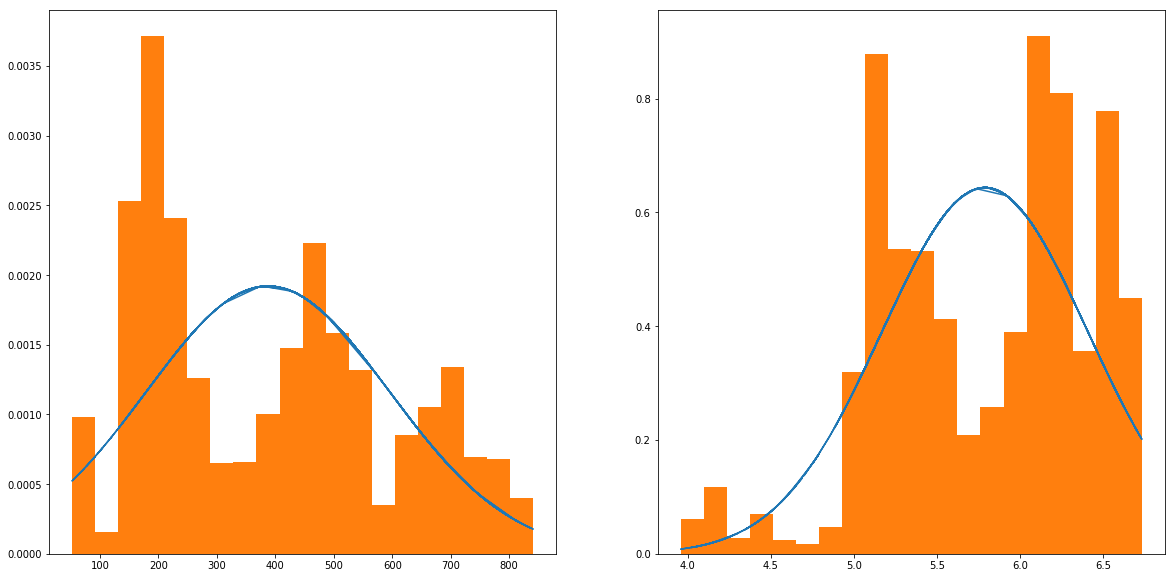

In [17]:
n=20
plt.subplot(1,2,1)
std = np.std(df['Close']) 
mean = np.mean(df['Close'])    
plt.plot(df['Close'],norm.pdf(df['Close'],mean,std))
plt.hist(df['Close'], bins=n, density=True);
#plt.subplot(1,2,2)
#np.sqrt(df['Close']).hist(bins=n)
plt.subplot(1,2,2)
std_log = np.std(np.log(df['Close'])) 
mean_log = np.mean(np.log(df['Close']))    
plt.plot(np.log(df['Close']),norm.pdf(np.log(df['Close']),mean_log,std_log))
plt.hist(np.log(df['Close']), bins=n, density=True);

- the distribution is not behaving very normal (gaussian), the log-transormation improves it

### Stationarity hypothesis

- Stationary means that the properties (mean, variance, etc) stay constant in time
- there are different ways to check that, first with a plot of the rolling-mean to see if it is constant over time
- a more sofisticated way is with ADF test though

In [18]:
rolmean = df_close.rolling(12).mean()
rolstd  = df_close.rolling(12).std()

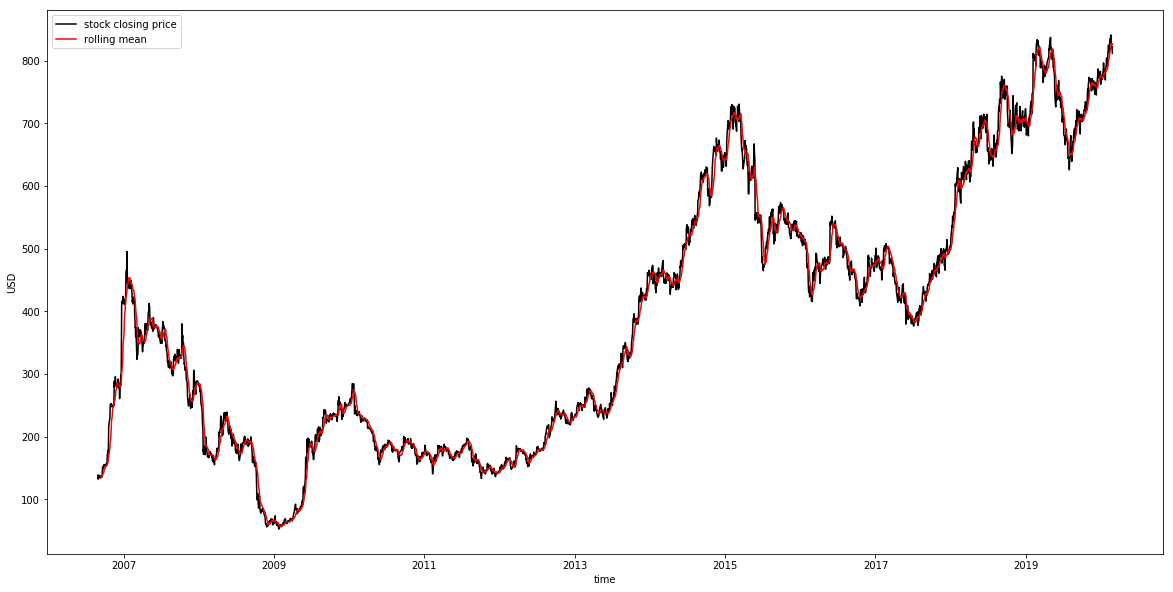

In [19]:
plt.plot(df_close,'k-', label='stock closing price')
plt.plot(rolmean, 'r-', label='rolling mean')
#plt.plot(rolstd, 'g-', label='rolling std')
plt.xlabel('time')
plt.ylabel('USD')
plt.legend();

- trend is clearly increasing -> the time series is clearly non-stationary, let's confirm with ADF test

In [20]:
adf = adfuller(df_close, autolag = 'AIC')
pval = adf[1]
pval

0.8766017616932285

- the Null Hypothesis of ADF test H0: the series has a unit root namely NON-stationary series
- since the pvalue is 0.52 higher than 0.05 there is no evidence to reject H0 and hence the series cannot be defined Stationary

### Decomposing the timeseries

- we now want to decompose the timeseries in trend, seasonal and residual components

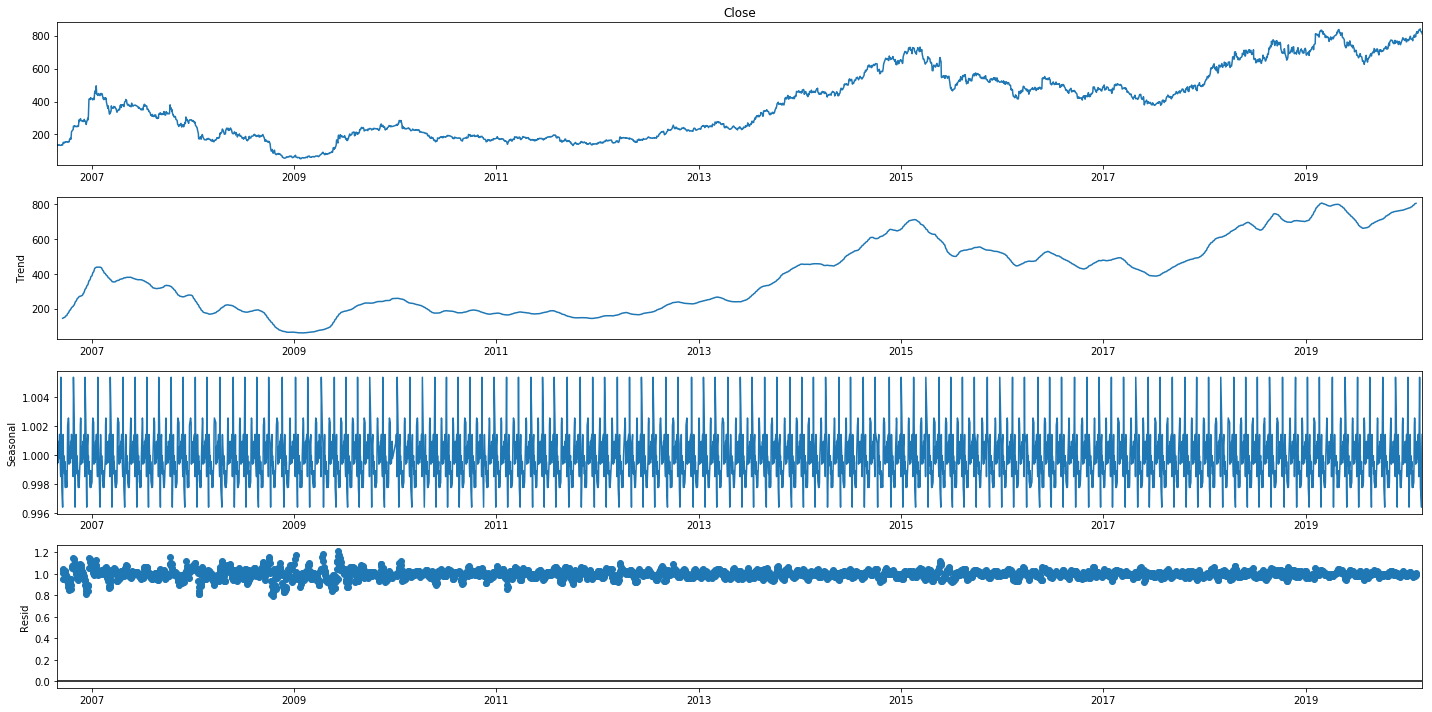

In [21]:
result = seasonal_decompose(df_close, model='multiplicative',period=30)
result.plot();

- the fact we have a trend (increasing trend) is another clear evidence of the non-stationarity of the timeseries
- also, the rising trend can be reduced by using the log-transformation, which we have also noticed earlier is good for the normality behaviour

### Finding best p,d,q for the ARIMA model

- first let's split the timeseries between training and test set
- let's see different ways to display the autocorrelation and actually use the acf, pcf plots to decide whether to have any MA, AR terms
- for the d coeff (differencing) we are going to use at least d=1 since the series is not stationary (it has a trend) as highlighted earlier
- after that we are going to create an ARIMA model with the auto_arima function and compare with the manual one

In [44]:
df_close_diff=df_close.copy()
for i in range(1, len(df_close)):
        df_close_diff.iloc[i] = df_close[i] - df_close[i - 1]

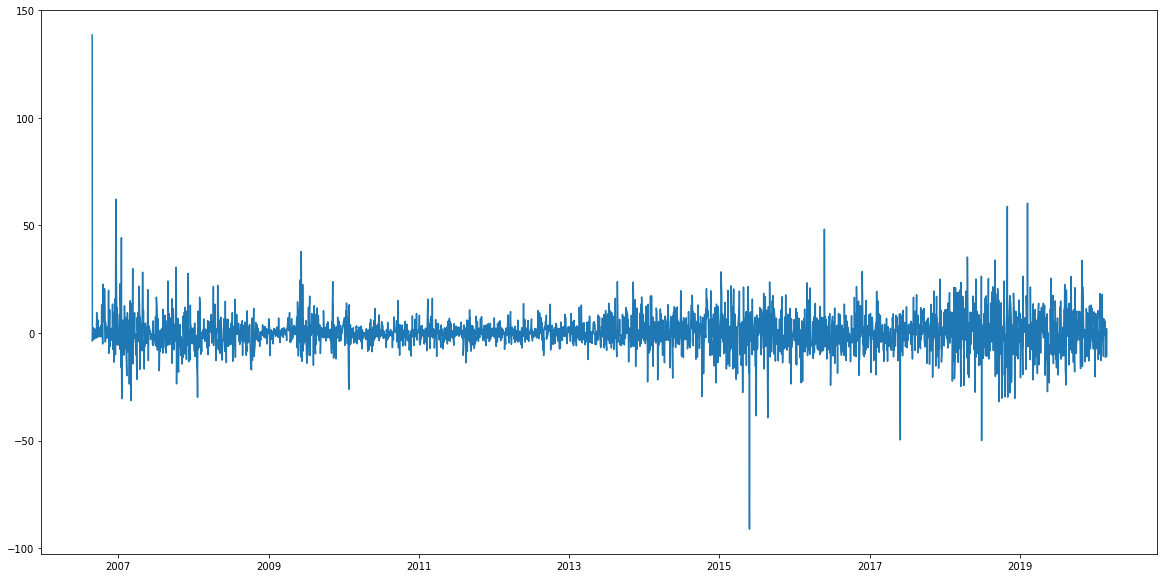

In [45]:
plt.plot((df_close_diff));

In [46]:
adf = adfuller(df_close_diff, autolag = 'AIC')
pval = adf[1]
pval

1.5646671670974155e-29

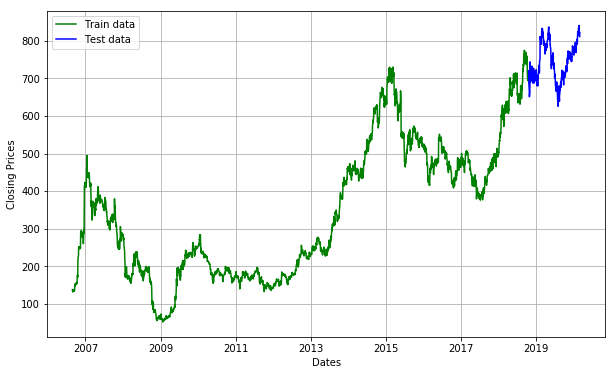

In [47]:
y_train, y_test = df_close[:int(len(df_close)*0.9)], df_close[int(len(df_close)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(y_train, 'green', label='Train data')
plt.plot(y_test, 'blue', label='Test data')
plt.legend();

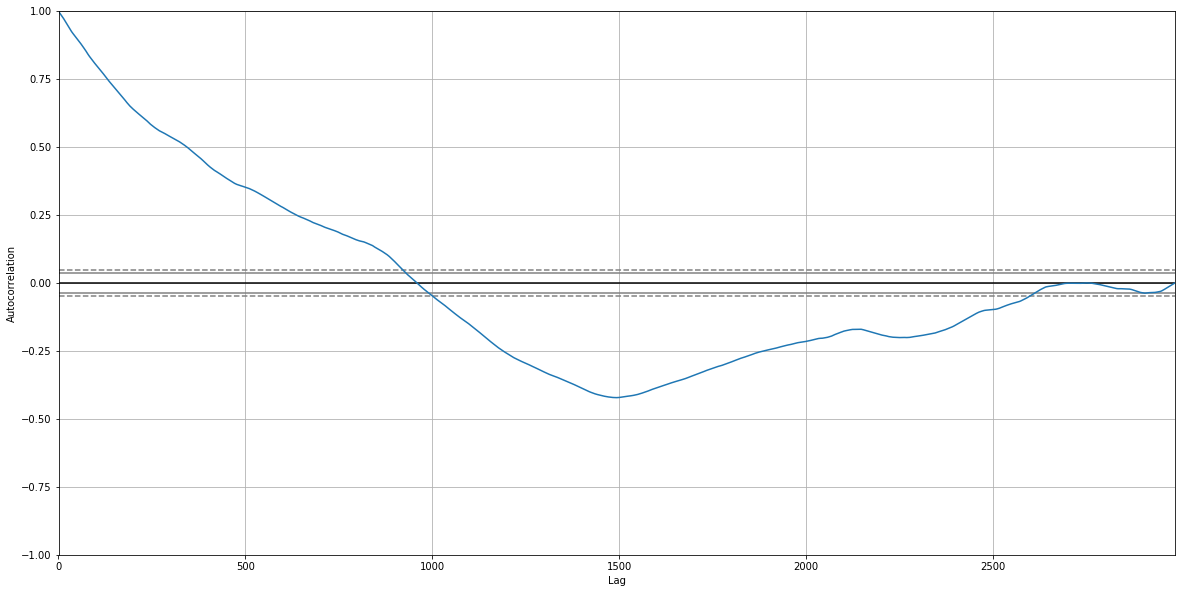

In [48]:
autocorrelation_plot(y_train);

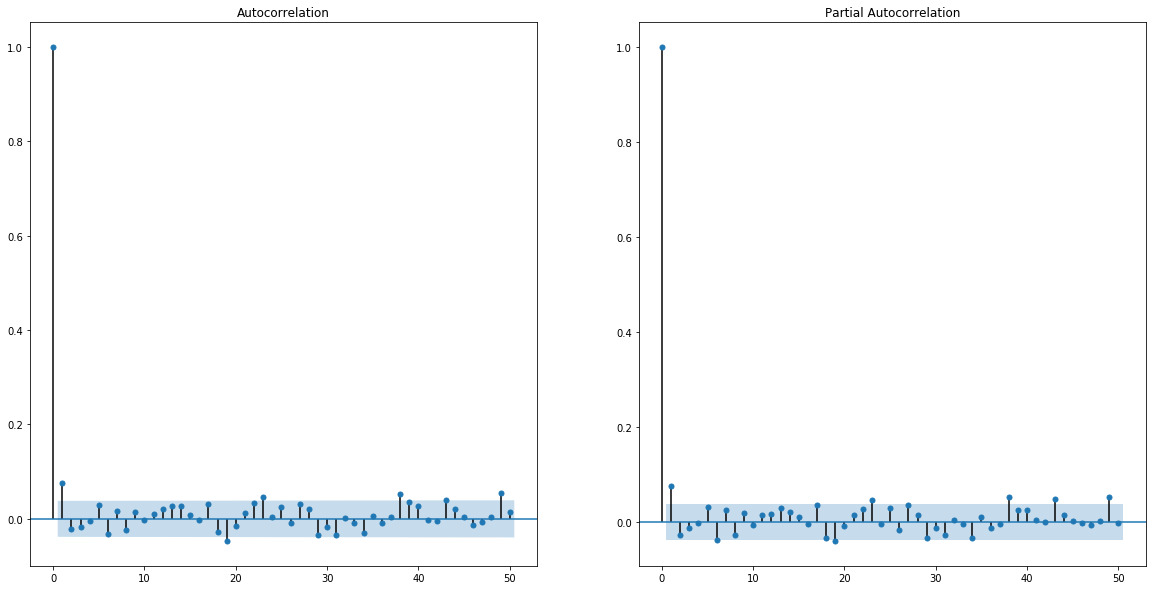

In [49]:
y_train_diff, y_test_diff = df_close_diff[:int(len(df_close_diff)*0.8)], df_close_diff[int(len(df_close_diff)*0.8):]
fig, ax = plt.subplots(1,2)
plot_acf(y_train_diff, lags=50, ax=ax[0]);
plot_pacf(y_train_diff, lags=50, ax=ax[1]);

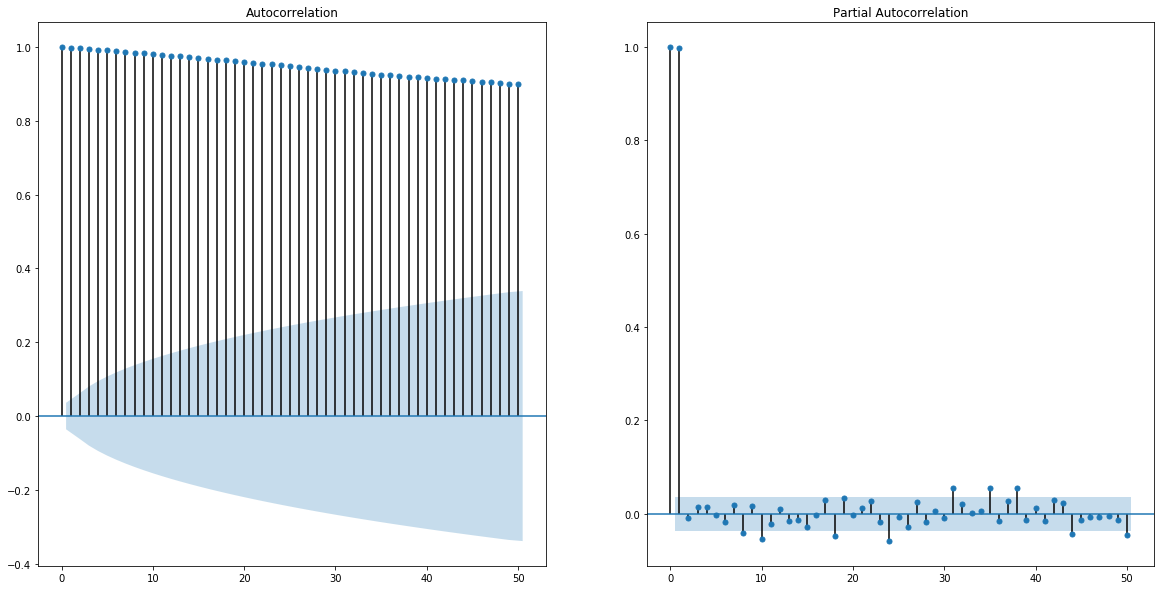

In [50]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1,2)
plot_acf(y_train, lags=50, ax=ax[0]);
plot_pacf(y_train, lags=50, ax=ax[1]);

- clearly the PACF plot shows a cut-off at k=1 meaning we should use a AR(p=1) model
- the ACF plot is not showing any cut-off or negative corr, instead it tails off exponentially: the error propagates to all terms after the first (at least to the first 50 terms). This confirms once more that the series is not stationary and instead presents a trend, the plot represents a long memory presence (and not random process!). For now let's just assume the order q=0 and see later on with auto_arima
- so we go for a AR(1,1,0) model to start! #d=0 because the log is not stationary

In [51]:
model = ARIMA(y_train, order=(1, 1, 1))  
model = model.fit()  
model.summary()

C:\Users\Matteo.Belloni\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Matteo.Belloni\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 2985
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -10368.368
Method:                       css-mle   S.D. of innovations              7.803
Date:                Tue, 02 Jun 2020   AIC                          20744.736
Time:                        18:44:08   BIC                          20768.742
Sample:                             1   HQIC                         20753.373
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1943      0.146      1.335      0.182      -0.091       0.480
ar.L1.D.Close    -0.8729      0.064    -13.548      0.000      -0.999      -0.747
ma.L1.D.Close     0.9087      0.055     16.391      0.000       0.800       1.017
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1456           +0.0000j            1.1456            0.5000
MA.1           -1.1005           +0.0000j            1.1005            0.5000
-----------------------------------------------------------------------------
"""

In [52]:
np.exp(0.0006)

1.0006001800360054

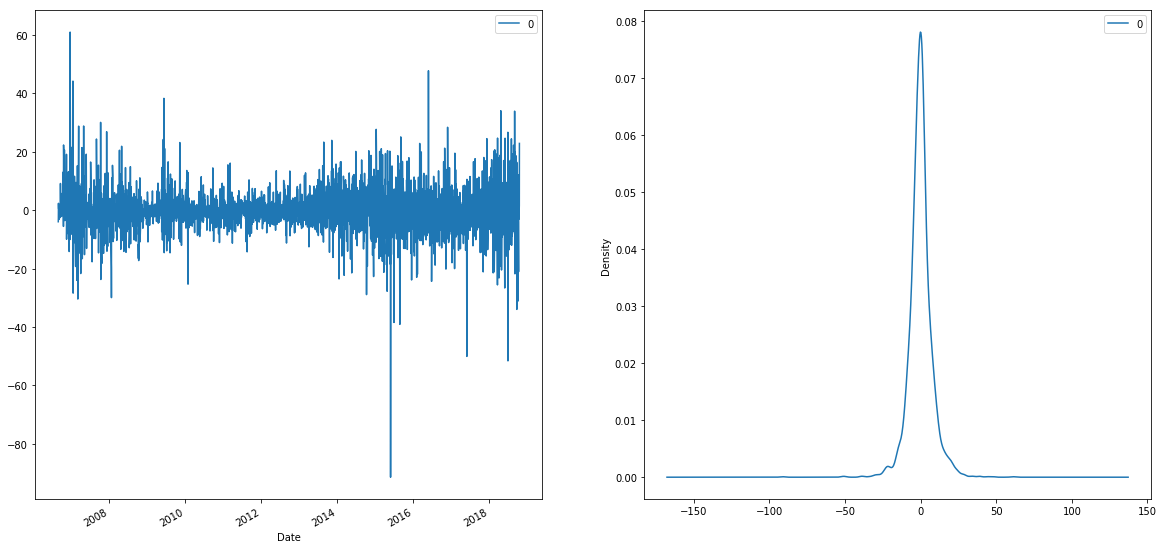

In [53]:
residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(ax=ax[0])
residuals.plot(kind='kde', ax=ax[1]);

In [54]:
residuals.describe()

,0
count,2.985000e+03
mean,-8.048215e-07
std,7.804611e+00
min,-9.142297e+01
25%,-3.637940e+00
50%,-8.906890e-02
75%,3.223606e+00
max,6.101775e+01


- there seems not to be any trend in the residuals (so d=1 is good!) and the density of residuals is gaussian and around 0 which again seems good

In [55]:
#model_auto = auto_arima(y_train, start_p=0, start_q=0, test='adf', max_p=3, max_q=3, m=1,d=1, seasonal=False, start_P = 0, D=0, trace=True,error_action='ignore',suppress_warnings=True, stepwise = True, stationary=True)
model_auto = auto_arima(y_train, seasonal=False, suppress_warnings=True, test='adf',m=1, stepwise=True, trace=True, stationarity=True)
model_auto


Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=20748.327, BIC=20784.335, Time=2.016 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=20756.782, BIC=20768.785, Time=0.066 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=20748.699, BIC=20766.703, Time=0.145 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=20748.064, BIC=20766.068, Time=0.652 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=20756.623, BIC=20762.624, Time=0.045 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=20748.798, BIC=20772.804, Time=2.436 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=20747.939, BIC=20771.944, Time=0.763 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=20748.638, BIC=20778.645, Time=1.054 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=20748.020, BIC=20778.027, Time=0.707 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=20745.037, BIC=20781.045, Time=3.521 seconds
Fit ARIMA(2,1,3)

ARIMA(maxiter=50, method='lbfgs', order=(2, 1, 4), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

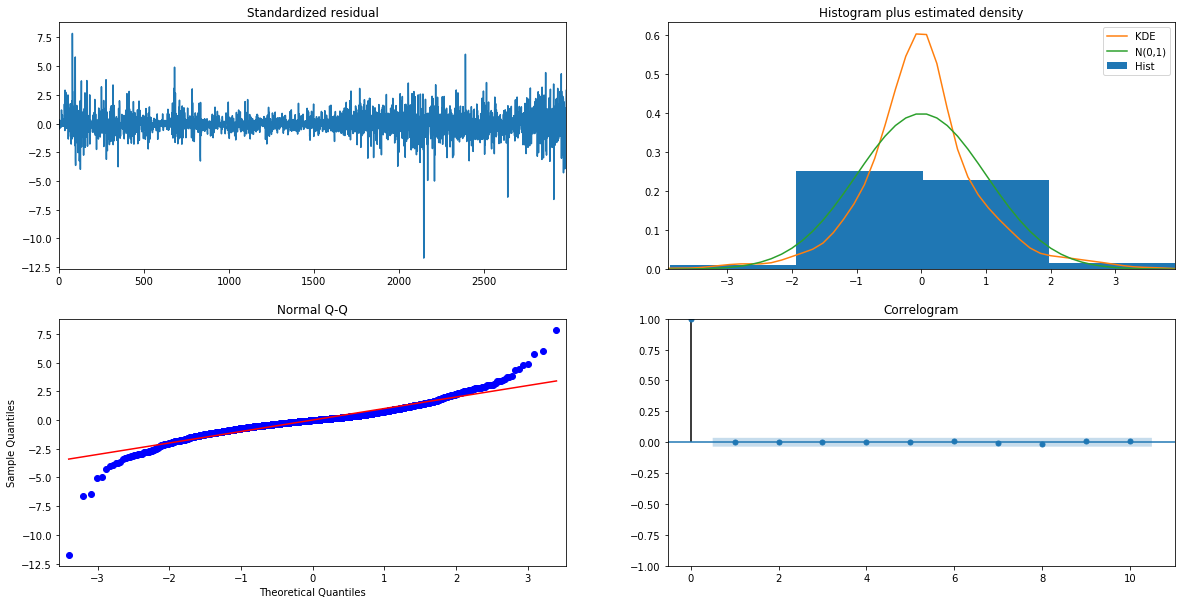

In [56]:
model_auto.plot_diagnostics();

Plot Diagnostic:
- Top left: the residuals fluctuate around the mean 0 and with a quite uniform variance
- Top right: the density plot suggest normal distribution with mean 0 of the residuals
- Bottom left: all the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed
- Bottom right: the Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model

In [57]:
model_1 = ARIMA(y_train, order=(3, 1, 3))  
model_1 = model_1.fit()  
model_1.summary()

C:\Users\Matteo.Belloni\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Matteo.Belloni\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 2985
Model:                 ARIMA(3, 1, 3)   Log Likelihood              -10359.062
Method:                       css-mle   S.D. of innovations              7.772
Date:                Tue, 02 Jun 2020   AIC                          20734.124
Time:                        18:45:19   BIC                          20782.134
Sample:                             1   HQIC                         20751.397
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1948      0.145      1.339      0.180      -0.090       0.480
ar.L1.D.Close    -0.6932      0.058    -11.855      0.000      -0.808      -0.579
ar.L2.D.Close    -0.8284      0.011    -72.901      0.000      -0.851      -0.806
ar.L3.D.Close    -0.8829      0.058    -15.117      0.000      -0.997      -0.768
ma.L1.D.Close     0.7325      0.050     14.609      0.000       0.634       0.831
ma.L2.D.Close     0.8299      0.009     87.600      0.000       0.811       0.848
ma.L3.D.Close     0.9177      0.050     18.301      0.000       0.819       1.016
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0960           -0.9965j            1.0011           -0.2347
AR.2            0.0960           +0.9965j            1.0011            0.2347
AR.3           -1.1302           -0.0000j            1.1302           -0.5000
MA.1            0.0926           -0.9957j            1.0000           -0.2352
MA.2            0.0926           +0.9957j            1.0000            0.2352
MA.3           -1.0896           -0.0000j            1.0896           -0.5000
-----------------------------------------------------------------------------
"""

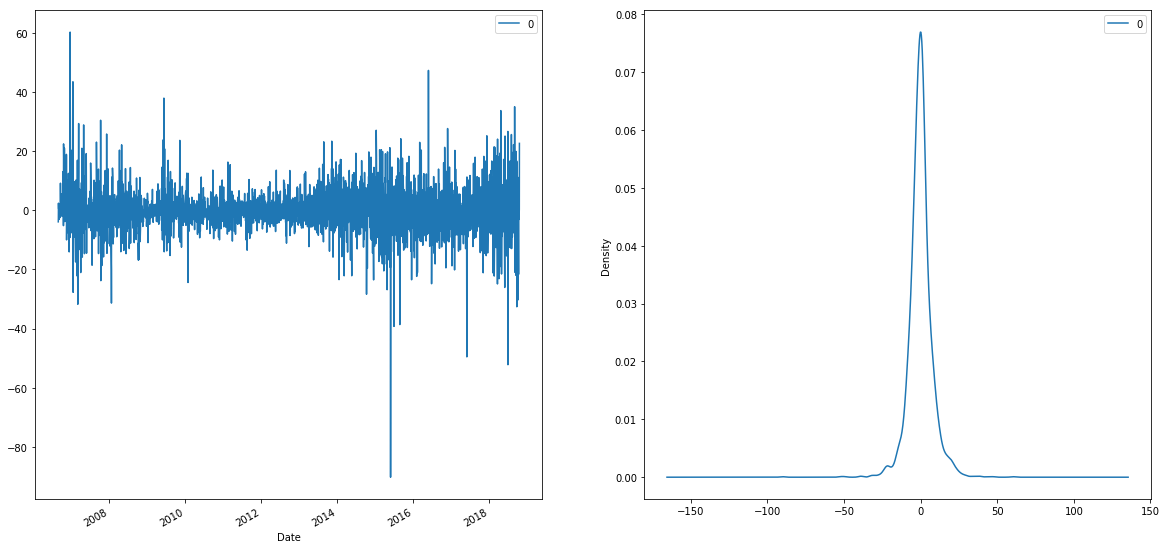

In [58]:
residuals_1 = pd.DataFrame(model_1.resid)
fig, ax = plt.subplots(1,2)
residuals_1.plot(ax=ax[0])
residuals_1.plot(kind='kde', ax=ax[1]);

In [59]:
residuals_1.describe()

,0
count,2985.000000
mean,-0.000629
std,7.780946
min,-90.259721
25%,-3.681657
50%,-0.098752
75%,3.274367
max,60.209788


### Model evaluation & forecast

In [60]:
forecast, se, conf = model.forecast(332) #for the arima model (chosen using ACF, PACF)
fc_series = pd.Series(forecast, index=y_test.index)

#forecast1, se1, conf1 = model_1.forecast(332) #for the auto_arima model
#fc_series1 = pd.Series(forecast1, index=y_test.index)

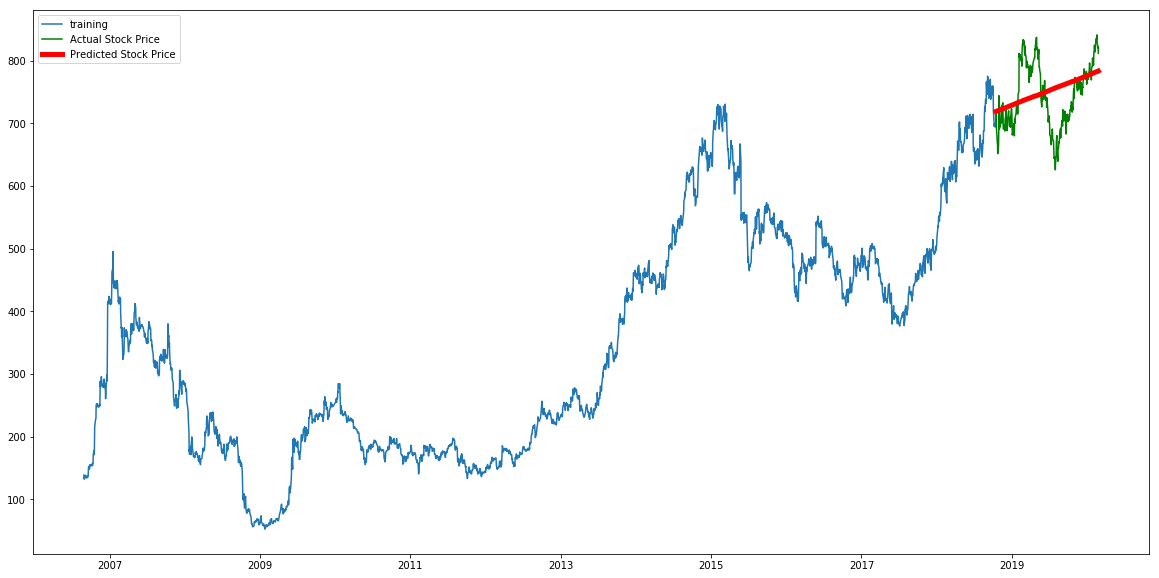

In [61]:
plt.plot(y_train, label='training')
plt.plot(y_test,'g', label='Actual Stock Price')
plt.plot(fc_series, 'red',label='Predicted Stock Price', linewidth=5)
#plt.plot(fc_series1, 'r',label='Predicted Stock Price')
plt.legend();

- calculate the error but first convert the timeseries back to its magnitude with the exponential (you transformed to log earlier..)

In [1]:
# plt.plot(np.exp(y_train), label='training')
# plt.plot(np.exp(y_test),'g', label='Actual Stock Price')
# plt.plot(np.exp(fc_series), 'red',label='Predicted Stock Price')
# #plt.plot(np.exp(fc_series1), 'r',label='Predicted Stock Price')
# plt.legend();

In [2]:
# np.exp(fc_series)

In [64]:
#for the arima model from ACF, PACF
mse_arima = mean_squared_error((y_test), (forecast))
print('MSE: '+str(mse_arima))
rmse_arima = np.sqrt(mse_arima)
print('RMSE: '+str(rmse_arima))
mape_arima = np.mean(np.abs((forecast) - (y_test))/np.abs((y_test)))
print('MAPE: '+str(mape_arima))
accuracy_from_mape_arima = 1-mape_arima
print('1-MAPE: '+str(accuracy_from_mape_arima))

MSE: 2444.091574671488
RMSE: 49.4377545472232
MAPE: 0.05401824683944857
1-MAPE: 0.9459817531605514


- which means that the model gets the forecast wrong on average by about 7.315

In [3]:
# #for the arima model from auto_arima
# mse_auto = mean_squared_error((y_test), (forecast1))
# print('MSE: '+str(mse_auto))
# rmse_auto = np.sqrt(mse_auto)
# print('RMSE: '+str(rmse_auto))
# mape_auto = np.mean(np.abs((forecast1) - (y_test))/np.abs((y_test)))
# print('MAPE: '+str(mape_auto))
# accuracy_from_mape_auto = 1-mape_auto
# print('accuracy from MAPE: '+str(accuracy_from_mape_auto))

- which means that the model gets the forecast wrong on average by about 7.316

In [67]:
null_model_log= y_train[len(y_train)-1] * np.ones(len(y_test))
null_model_log_series = pd.Series(null_model_log, index=y_test.index)
null_model = (null_model_log)  #as null model we are using the LastValue model
mse_lv = mean_squared_error((y_test), null_model)
print("MSE: "+str(mse_lv))
rmse_lv = np.sqrt(mse_lv)
print("RMSE: "+str(rmse_lv))
mape_lv = np.mean(np.abs(null_model - (y_test))/np.abs((y_test)))
print('MAPE: '+str(mape_lv))
accuracy_from_mape_lv = 1-mape_lv
print('accuracy from MAPE: '+str(accuracy_from_mape_lv))

MSE: 3129.1943524096364
RMSE: 55.93920228613951
MAPE: 0.06040700787571953
accuracy from MAPE: 0.9395929921242805


- which means that the model gets the forecast wrong on average by about 7.43

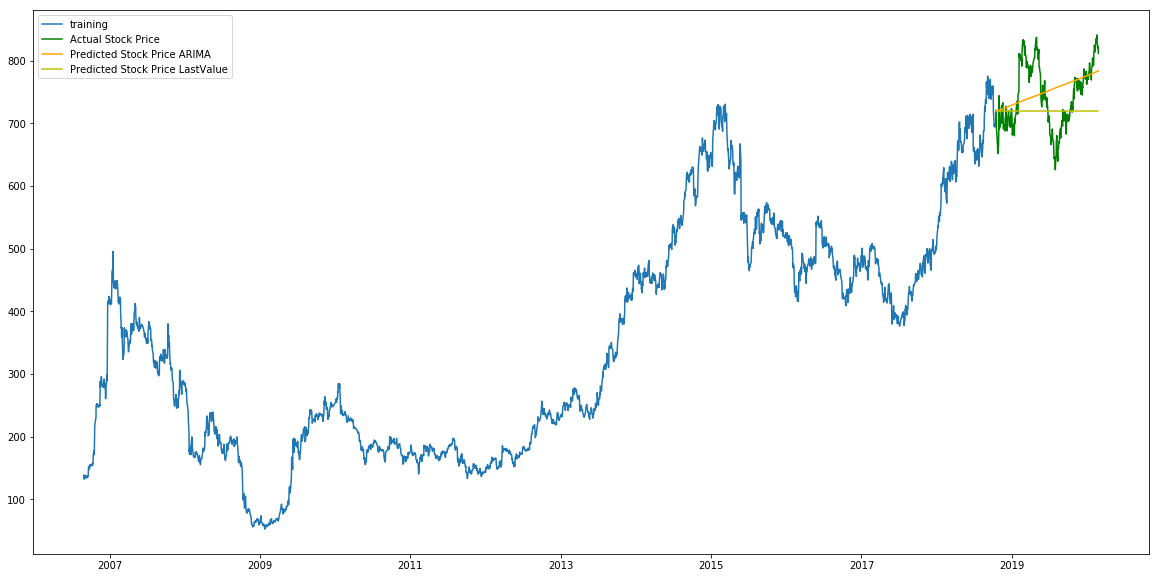

In [68]:
plt.plot(y_train, label='training')
plt.plot(y_test,'g', label='Actual Stock Price')
plt.plot(fc_series, 'orange',label='Predicted Stock Price ARIMA')
#plt.plot(fc_series1, 'r',label='Predicted Stock Price autoARIMA')
plt.plot(null_model_log_series, 'y',label='Predicted Stock Price LastValue')
plt.legend();

### Other possible models: Linear Regression, Simple Average, Moving Average

In [69]:
#Linear Regression: use Year, Month, DayOfWeek as predictors
new_data = pd.DataFrame(index=range(0,len(df_close)),columns=['Date', 'Close'])
new_data['Date'] = df_close.index
new_data['Close'] = df_close.values

In [70]:
new_data['Year'] = pd.DatetimeIndex(new_data['Date']).year
new_data['Month'] = pd.DatetimeIndex(new_data['Date']).month
new_data['Day'] = pd.DatetimeIndex(new_data['Date']).dayofweek #Monday is 0

In [71]:
train_new = new_data[3:int(len(df_close)*0.9)]
test_new = new_data[int(len(df_close)*0.9):]
X_train_new = train_new[['Year','Month','Day']]
y_train_new = train_new['Close']
X_test_new = test_new[['Year','Month','Day']]
y_test_new = test_new['Close']

In [72]:
model_reg = LinearRegression()
model_reg.fit(X_train_new,y_train_new)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [73]:
model_reg.intercept_, model_reg.coef_

(-74392.87130316859, array([37.13366823,  2.46026168, -0.18709804]))

In [4]:
# y_test_new[2652], -69425+34.66*2017 + 2.93*6 -0.067*1,

In [75]:
mse_reg = mean_squared_error((y_test_new), (model_reg.predict(X_test_new)))
print("MSE: "+str(mse_reg))
rmse_reg = np.sqrt(mse_reg)
print("RMSE: "+str(rmse_reg))
mape_reg = np.mean(np.abs((model_reg.predict(X_test_new)) - (y_test_new))/np.abs((y_test_new)))
print('MAPE: '+str(mape_reg))
accuracy_from_mape_reg = 1-mape_reg
print('accuracy from MAPE: '+str(accuracy_from_mape_reg))

MSE: 24193.132385085464
RMSE: 155.5414169444443
MAPE: 0.19617420349197137
accuracy from MAPE: 0.8038257965080287


C:\Users\Matteo.Belloni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


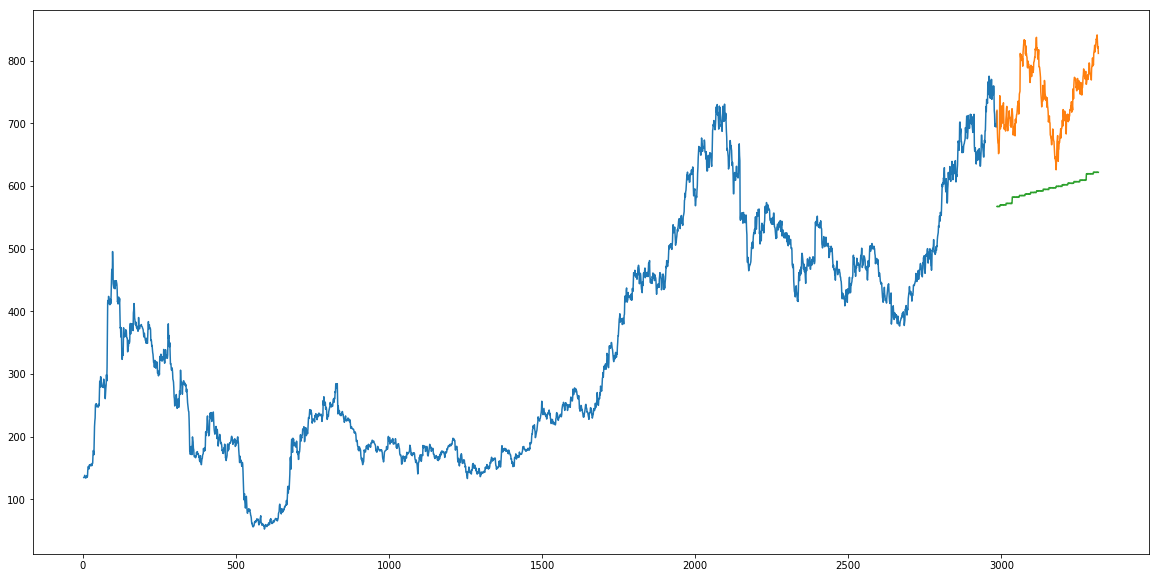

In [76]:
test_new['Predictions']=model_reg.predict(X_test_new)
plt.plot(train_new['Close'])
plt.plot(test_new[['Close','Predictions']]);

In [77]:
#Simple Average: take average of y_train and use that as your forecasted for every next value
SimpleAverage = y_train.mean()
model_simpleavg = SimpleAverage * np.ones(len(y_test))
model_simpleavg_exp = (model_simpleavg)

mse_sa = mean_squared_error((y_test), model_simpleavg_exp)
print("MSE: "+str(mse_sa))
rmse_sa = np.sqrt((mse_sa))
print("RMSE: "+str(rmse_sa))
mape_sa = np.mean(np.abs(model_simpleavg_exp - (y_test))/np.abs((y_test)))
print('MAPE: '+str(mape_sa))
accuracy_from_mape_sa = 1-mape_sa
print('accuracy from MAPE: '+str(accuracy_from_mape_sa))

MSE: 161467.39533188983
RMSE: 401.83005777553507
MAPE: 0.5344883385750892
accuracy from MAPE: 0.46551166142491085


In [78]:
#Simple Average: take average of y_train and use that as your forecasted for every next value
model_movavg = y_train[int(len(y_train)*0.992):].mean() * np.ones(len(y_test)) #average of the last 10 elements of y_train
model_movavg_exp = (model_movavg)

mse_ma = mean_squared_error((y_test), model_movavg_exp)
print("MSE: "+str(mse_ma))
rmse_ma = (mse_ma)
print("RMSE: "+str(rmse_ma))
mape_ma = np.mean(np.abs(model_movavg_exp - (y_test))/np.abs((y_test)))
print('MAPE: '+str(mape_ma))
accuracy_from_mape_ma = 1-mape_ma
print('accuracy from MAPE: '+str(accuracy_from_mape_ma))

MSE: 2613.204537315932
RMSE: 2613.204537315932
MAPE: 0.05875055804077825
accuracy from MAPE: 0.9412494419592218


In [79]:
performance_table = pd.DataFrame(index = range(0,4), columns =['Model','MSE','RMSE','MAPE','1-MAPE'])
model_names = ['ARIMA(1,1,1)','Linear Regression','Last Value','Simple Average']
mses = [mse_arima, mse_reg, mse_lv, mse_sa]
rmses = [rmse_arima, rmse_reg, rmse_lv, rmse_sa]
mapes = [mape_arima, mape_reg, mape_lv, mape_sa]
accuracies = [accuracy_from_mape_arima, accuracy_from_mape_reg, accuracy_from_mape_lv, accuracy_from_mape_sa]
performance_table.Model = model_names
performance_table.MSE = mses
performance_table.RMSE = rmses
performance_table.MAPE = mapes
performance_table['1-MAPE'] = accuracies
performance_table.sort_values(by='RMSE')

,Model,MSE,RMSE,MAPE,1-MAPE
0,"ARIMA(1,1,1)",2444.091575,49.437755,0.054018,0.945982
2,Last Value,3129.194352,55.939202,0.060407,0.939593
1,Linear Regression,24193.132385,155.541417,0.196174,0.803826
3,Simple Average,161467.395332,401.830058,0.534488,0.465512


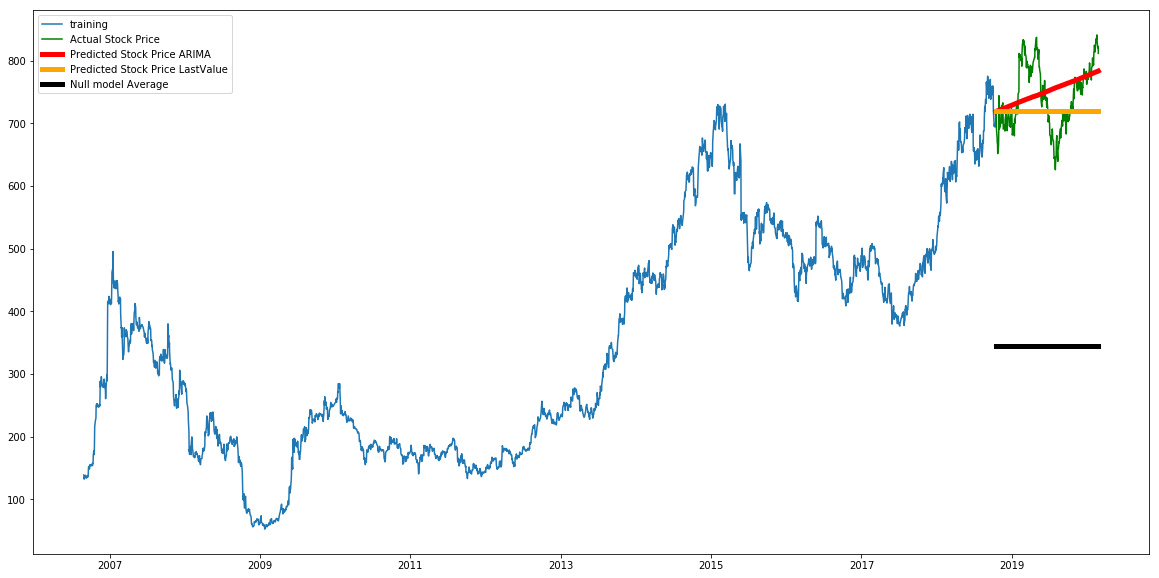

In [80]:
plt.plot(y_train, label='training')
plt.plot(y_test,'g', label='Actual Stock Price')
plt.plot(fc_series, 'red',label='Predicted Stock Price ARIMA', linewidth=5)
#plt.plot(fc_series1, 'r',label='Predicted Stock Price autoARIMA')
plt.plot(null_model_log_series, 'orange',label='Predicted Stock Price LastValue', linewidth=5)
model_simpleavg_series = pd.Series(model_simpleavg, index=y_test.index)
plt.plot(model_simpleavg_series, 'k',label='Null model Average', linewidth=5)

plt.legend();

In [ ]:
model_simpleavg